# Machine Learning Using PySpark and MLLib

**Bartley Richardson, PhD**  
_Principal Data Scientist_  
_Sotera Defense Solutions, Inc. || Advanced Projects and Technologies_

16 February 2017

_This notebook was created for the NOVA Data Science meetup on 16 February 2017. The focus of the notebook is on basic PySpark MLLib usage. All examples and code are provided as-is with no guarantee of correctness. The user assumes all risks from reusing this code._

---

## Supervised Learning Example

### Get the data and load into a dataframe

We're going to use the [Bank Marketing data set](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) from 2012. It includes some categorical features as well as numeric features, and there are only two target classes (yes or no if the client subscribed a term deposit). This is useful since PySpark's version of MLLib does not currently support multi-class classification using logistic regression.

In [1]:
# first line reads in the smaller file (10% of data) for testing
# df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=';').load('./bank-additional/bank-additional.csv')
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=';').load('./data/bank-additional-full.csv')

It's useful to see the schema of the data we just imported, even though we know what the website says.

In [2]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



We also would like to know how many rows we're dealing with here.

In [3]:
print "Number of rows in dataset =", df.count()

Number of rows in dataset = 41188


### Data transformations

The target variable is named y, so let's rename it to something that makes a bit more sense (we'll use "label" in this case).

In [4]:
df = df.withColumnRenamed("y","label")

There are a number of categorical variables that we'd like to use in our classifier, so we'll need to convert them to a numerical type. [StringIndexer](http://spark.apache.org/docs/latest/ml-features.html#stringindexer) in pyspark.ml is useful for this. Although we won't use it in this example, there is a complementary function ([IndexToString](http://spark.apache.org/docs/latest/ml-features.html#indextostring)) that can map a column of label indices back to their original string (original categorical) values. Handy!

For this first model, we're going to select some features seemingly randomly (I know, but it's just the first time through to demo). We'll use one numerical field as well as one categorical field. The numerical fields are fine, but we'll need to use StringIndexer to deal with the categorical field. Since the label is also categorical ("yes" or "no"), we'll also have to deal with that too.

In [5]:
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol="job", outputCol="job_index"),
            StringIndexer(inputCol="loan", outputCol="loan_index"),
            StringIndexer(inputCol="label", outputCol="label_index")]

The [Pipeline](http://spark.apache.org/docs/2.0.0/api/python/pyspark.ml.html#pyspark.ml.Pipeline) function is useful when we have multiple steps.

In [6]:
from pyspark.ml import Pipeline
index_pipeline = Pipeline(stages=indexers)
indexed_df = index_pipeline.fit(df).transform(df)

If we inspect one row of the indexed_df, we can see that we now have numeric values for the two categorical fields.

In [7]:
indexed_df.take(1)

[Row(age=56, job=u'housemaid', marital=u'married', education=u'basic.4y', default=u'no', housing=u'no', loan=u'no', contact=u'telephone', month=u'may', day_of_week=u'mon', duration=261, campaign=1, pdays=999, previous=0, poutcome=u'nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, label=u'no', job_index=8.0, loan_index=0.0, label_index=0.0)]

The logistic regression algorithm in PySpark MLLib is expecting a RDD of [LabeledPoint](https://spark.apache.org/docs/latest/mllib-data-types.html#labeled-point) values. We'll need to write a simple parsing function in order to create this.

In [8]:
from pyspark.mllib.regression import LabeledPoint
def parse_data_1(row):
    features = [row.age, row.loan_index]
    
    return LabeledPoint(row.label_index, features)

In [9]:
parsed_data = indexed_df.rdd.map(parse_data_1)

And now we'll inspect a few points from the parsed data RDD.

In [10]:
parsed_data.take(2)

[LabeledPoint(0.0, [56.0,0.0]), LabeledPoint(0.0, [57.0,0.0])]

In order to train the model, we'll split our data into training (70%) and testing (30%). We can use the built-in [randomSplit function](https://spark.apache.org/docs/1.6.2/api/java/org/apache/spark/rdd/RDD.html#randomSplit(double[],%20long) for this.

In [11]:
train, test = parsed_data.randomSplit([0.7, 0.3])

### Create the model and evaluate accuracy

We're finally ready to train our logstic regression model. For this case, we're going to use [LogisticRegressionWithLBFGS](http://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html) ([more information](https://en.wikipedia.org/wiki/Limited-memory_BFGS) on limited-memory BFGS, if you're interested).

In [12]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

logit_model_1 = LogisticRegressionWithLBFGS.train(train)

Now that we have the model, we'll use the testing data to evaluate the accuracy of the model. We'll use the model we created above to predict labeles for the testing data and then compare to the actual label.

In [13]:
labels_predictions = test.map(lambda p: (p.label, logit_model_1.predict(p.features)))
test_accuracy_1 = labels_predictions.filter(lambda (v, p): v == p).count() / float(test.count())
print "Accuracy of first model =", test_accuracy_1

Accuracy of first model = 0.888240064882


This isn't terrible, but we can maybe do better. Let's introduce a few more features and create a second model.

### A second model with more/different features

In addition to the features used in the first model, we're now also going to use `default`, `poutcome` (how did they participate in the previous campaign), and two variables (`pdays` and `pcampaign`) that show how the client was contacted in the previous campaign. We'd also like to add in some economic factors, so we'll include `euribor3m`.

For completeness, we'll reproduce the steps in creating the above model (including the import statements).

In [14]:
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol="job", outputCol="job_index"),
           StringIndexer(inputCol="label", outputCol="label_index"),
           StringIndexer(inputCol="default", outputCol="default_index"),
           StringIndexer(inputCol="poutcome", outputCol="poutcome_index")]

In [15]:
from pyspark.ml import Pipeline
index_pipeline = Pipeline(stages=indexers)
indexed_df = index_pipeline.fit(df).transform(df)

Again, let's take one row to make sure we did everything correct.

In [16]:
indexed_df.take(1)

[Row(age=56, job=u'housemaid', marital=u'married', education=u'basic.4y', default=u'no', housing=u'no', loan=u'no', contact=u'telephone', month=u'may', day_of_week=u'mon', duration=261, campaign=1, pdays=999, previous=0, poutcome=u'nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, label=u'no', job_index=8.0, label_index=0.0, default_index=0.0, poutcome_index=0.0)]

Looks good! Now we'll slightly modify the parse_data_1 function to create one that deals with the additional features. 

In [17]:
from pyspark.mllib.regression import LabeledPoint
def parse_data_2(row):
    features = [row.age, row.campaign, row.pdays, row.previous, row.poutcome_index,
                row.job_index, row.default_index, row.euribor3m]
    
    return LabeledPoint(row.label_index, features)

In [18]:
parsed_data = indexed_df.rdd.map(parse_data_2)

We'll split the data again.

In [19]:
train, test = parsed_data.randomSplit([0.7, 0.3])

In [20]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

logit_model_2 = LogisticRegressionWithLBFGS.train(train)
labels_predictions_2 = test.map(lambda p: (p.label, logit_model_2.predict(p.features)))
test_accuracy_2 = labels_predictions_2.filter(lambda (v, p): v == p).count() / float(test.count())
print "Accuracy of second model =", test_accuracy_2

Accuracy of second model = 0.896832505496


The accuracy is somewhat improved, but at the cost of adding complexity to the model in terms of number of featrures. In fact, there are much better regression models that can be created.

For now, we'll move on to an unsupervised learning example.

---

## Unsupervised Learning Example

Supervised learning is great when you have labels, but what about when don't have those? Then we can turn to unsupervised techniques.

[Word2Vec](https://code.google.com/archive/p/word2vec/) is a shallow, two-layer neural network that is used to learn word embeddings and embed them in a high-dimensional vector space. There are many applications for Word2Vec, and they need not be limited to natural language. However, for the purposes of this talk, natural language is the most straightforward and easy to understand. Thankfully, Word2Vec is built into many packages and technologies, including [MLLib](https://spark.apache.org/docs/latest/mllib-feature-extraction.html#word2vec).

In [1]:
from pyspark.mllib.feature import Word2Vec
import pandas as pd
import seaborn as sns

To illustrate Word2Vec, we're going to use a fairly contrived document. The document contains lists of analogies in the form:

    X is to Y as A is to B
    
This is a fairly well-known document and available [many](https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt) [places](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb).

In [2]:
doc = sc.textFile("./data/questions-words.txt").map(lambda line: line.split(" "))

Just to get a handle on the file, let's see how many lines there are.

In [3]:
doc.count()

19558

And now we'll take a look at what's in the file.

In [4]:
doc.take(10)

[[u':', u'capital-common-countries'],
 [u'Athens', u'Greece', u'Baghdad', u'Iraq'],
 [u'Athens', u'Greece', u'Bangkok', u'Thailand'],
 [u'Athens', u'Greece', u'Beijing', u'China'],
 [u'Athens', u'Greece', u'Berlin', u'Germany'],
 [u'Athens', u'Greece', u'Bern', u'Switzerland'],
 [u'Athens', u'Greece', u'Cairo', u'Egypt'],
 [u'Athens', u'Greece', u'Canberra', u'Australia'],
 [u'Athens', u'Greece', u'Hanoi', u'Vietnam'],
 [u'Athens', u'Greece', u'Havana', u'Cuba']]

Cool, but what about seeing other items present in the document? We can use the `sample` [function](http://takwatanabe.me/pyspark/generated/generated/pyspark.RDD.sample.html) to accomplish this. It's faster than the `takeSample` [function](http://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#takeSample), but the downside is it's sometimes difficult to know the fraction you need (especially if you don't want to call `count`).

In [5]:
doc.sample(False, 0.001, 1824).collect()

[[u'Funafuti', u'Tuvalu', u'Lusaka', u'Zambia'],
 [u'Nicosia', u'Cyprus', u'Yerevan', u'Armenia'],
 [u'Philadelphia', u'Pennsylvania', u'Atlanta', u'Georgia'],
 [u'Shreveport', u'Louisiana', u'Denver', u'Colorado'],
 [u'Tacoma', u'Washington', u'Sacramento', u'California'],
 [u'grandpa', u'grandma', u'grandson', u'granddaughter'],
 [u'sons', u'daughters', u'man', u'woman'],
 [u'calm', u'calmly', u'occasional', u'occasionally'],
 [u'fortunate', u'fortunately', u'possible', u'possibly'],
 [u'warm', u'warmer', u'high', u'higher'],
 [u'dog', u'dogs', u'pig', u'pigs']]

Okay, so there _are_ other analogies in there. That's a good sign! Ready for the magic? Don't blink, it happens fast.

In [6]:
model = Word2Vec().setWindowSize(2).setSeed(7712).fit(doc)

Did you miss it? We already created a Word2Vec model. Sure, there are quite a few [additional options available](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec). Perhaps the most useful are setting the vector size (the dimensionally used for the embedding) and the window size. The defaults are 100 and 5, respectively. Our sentences (analogies, in this case) aren't long at all, so we've restricted the window size. We've also seeded manually in order to reproduce results.

One thing we can do is query the model for synonyms of a particular word. This doesn't necessairly mean the same thing as the English language definition of synonym but rather means words that have similar embedding (via cosine similarity) to the given word.

In [7]:
model.findSynonyms("girl", 10)

[(u'mother', 0.99511222880580985),
 (u'wife', 0.99376529795880253),
 (u'father', 0.99293227308015253),
 (u'prince', 0.9928483703846005),
 (u'niece', 0.99178970525458698),
 (u'grandpa', 0.99142580440698969),
 (u'boy', 0.99102816416405859),
 (u'daughters', 0.99097605454538373),
 (u'grandson', 0.98929323134333214),
 (u'groom', 0.98920963163230535)]

Makes a little bit of sense, especially if you look hard.

One huge advantage of Word2Vec is the ability to perform vector arithmetic on the embedded words. The classic example is:

    man + king - queen = woman
    
We can do something similar here, but we'll use:

    girl + brother - boy

In [8]:
vector_1 = model.transform("girl")+model.transform("brother")-model.transform("boy")

In [9]:
model.findSynonyms(vector_1,10)

[(u'granddaughter', 0.99000022770354801),
 (u'stepbrother', 0.98983607273536456),
 (u'son', 0.98918080032709155),
 (u'brother', 0.98904372669344165),
 (u'policewoman', 0.98629621221582175),
 (u'stepson', 0.98617345893917674),
 (u'king', 0.98525168986706579),
 (u'sister', 0.98524409491506881),
 (u'stepsister', 0.9836585478963995),
 (u'stepmother', 0.98230900560410139)]

Does it make sense? A little. We see that most of the words have something to do with being female, and `sister` is even in the list (pretty high too).

What we did was use the model to transform the word into the vector (a DenseVector in this case). It looks like this.

In [10]:
model.transform("brother")

DenseVector([0.1989, -0.1743, -0.0939, 0.1083, -0.0057, -0.1498, -0.1187, -0.0132, -0.0441, 0.1995, -0.1299, 0.0356, -0.0315, -0.081, 0.1061, 0.1098, -0.1722, -0.2281, -0.1308, 0.39, 0.062, 0.0263, -0.0253, -0.1009, -0.0276, 0.1377, 0.0331, -0.0841, 0.0095, -0.0254, 0.0062, -0.2672, -0.1616, 0.0232, 0.0879, -0.1209, 0.1452, 0.2707, -0.13, -0.1577, -0.2147, 0.0702, 0.1561, 0.0161, -0.0935, -0.1631, 0.0033, -0.1504, 0.1927, -0.1849, -0.0802, 0.2974, -0.0695, 0.0316, 0.0955, -0.0156, 0.0607, -0.0872, 0.1317, 0.1149, -0.2147, -0.0967, 0.0664, -0.0117, 0.0688, 0.1525, -0.1064, -0.0936, -0.1205, -0.0342, 0.0583, 0.0168, 0.0491, 0.0715, -0.1636, -0.0149, -0.1252, 0.0505, 0.1868, -0.212, -0.1135, -0.07, 0.1714, 0.1491, 0.0226, 0.0201, 0.096, -0.1624, -0.0775, -0.0283, -0.1794, -0.1446, 0.3148, 0.1816, -0.0495, 0.1519, -0.0773, -0.2093, 0.1817, -0.0542])

This is all well and good, but what if we want to visualize the results? Unless you have a 100-dimensional display, this can get difficult. Thankfully, there are some simple ways we can still get a nice two-dimensional representation of the vectors. 

Pick your favorite dimensionality reduction technique. We'll use [t-SNE](https://lvdmaaten.github.io/tsne/) (of course we will, it won a prize!). We're cheating a bit and using sklearn though.

In [11]:
import numpy as np
from sklearn.manifold import TSNE

In order to get down to two dimensions, we specify `n_components=2`.

In [12]:
tsne_model = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)

We don't want to use t-SNE on the words, just the vectors. So we'll use the built-in `getVectors()` function to extract only the high-dimenstional vectors from the Word2Vec model.

In [13]:
vects = model.getVectors()

Now we can do the dimensionality reduction.

In [14]:
tsne_out = tsne_model.fit_transform(vects.values())

Okay, now what? The whole point of doing this was to get a better picture (get it, picture?) of what the word embeddings look like. So we'll plot it. 

_Disclaimer: I very much dislike plotting using Matplotlib. Nothing against it or you if you love it; it's just not for me. So what follows isn't super efficient, but it keeps me happy._

Let's create a Pandas dataframe with the t-SNE (x, y) output.

In [15]:
tsne_df = pd.DataFrame(tsne_out, columns=['x','y'])

Now we can plot it! I'll use [Seaborn](http://seaborn.pydata.org) just to make it pretty. And don't forget to set alpha transparency!

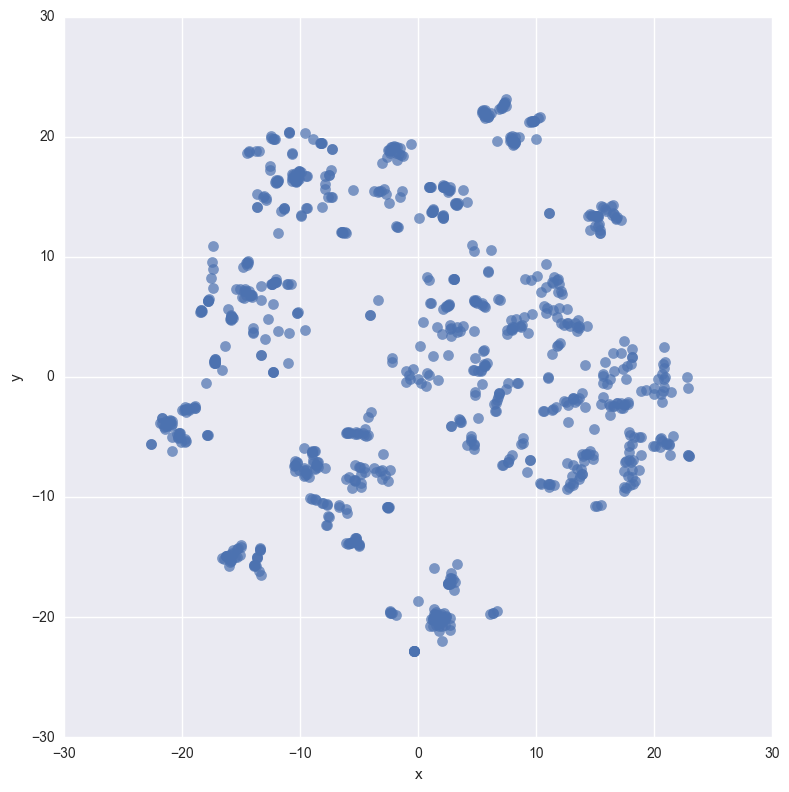

In [16]:
%matplotlib inline
ax = sns.lmplot('x', 'y', tsne_df, fit_reg=False, size=8,
               scatter_kws={'alpha':0.7,'s':60})

It looks nice, and you can even see clusters (although they may just be in your imagination). Without plotting again and putting labels on the plot, we can add the words back into the dataframe then manually slice the dataframe to see what words appear together.

In [17]:
tsne_df["word"] = vects.keys()

In [18]:
tsne_df[(tsne_df['x']>0) & (tsne_df['x']<11) & 
       (tsne_df['y']>18) & (tsne_df['y']<30)][:10]

,x,y,word
0,8.062794,19.277528,serious
32,8.170368,19.584638,professionally
43,8.138296,19.433303,precisely
67,6.137148,21.970283,professional
78,10.305916,21.636797,apparently
144,7.975042,20.097824,cheerful
173,7.935768,19.554603,suddenly
181,9.644266,21.247836,infrequently
232,7.407469,22.551198,obvious
268,7.230676,22.832586,reluctantly


In the above scenario, we're looking at the top-most grouping, just to the right of center. It's primarily comprised of adverbs that end in -ly, which is an interesting find.

However, without doing this for every grouping or using a tool like [Plotly](https://plot.ly) (which is seriously cool, and you should check it out if you haven't used it...just use the offline mode though), we're at an impass. Here's where we'll cheat a bit more in the interest of time. In order to visualize this, we'll export the data and read it into Tableau.

In [39]:
tsne_df.to_csv("./tsne_wordvects.tab", sep='\t')

From Tableau, we can obtain a plot of this data. We'll color it by words that represent a country (orange) and those that don't. We see that many of the countries group together, with the exception of Georgia. Since Georgia is also a US state, it makes a little bit of sense that it may be confused with that and grouped with US states.

#### Country vs Non-Country
![Country vs NonCountry](./images/image_country_vs_noncountry_v1.png)

As of Tableau v10, you can do _k_-means clustering right inside of Tableau. Let's do this (letting Tableau determine what _k_ should be). Tableau chooses k=16, and we can view the resuls right here.

#### k-Means Clustering After t-SNE
![k-Means Clustering After t-SNE](./images/image_cluster_after_tsne_v1.png)

This isn't terribly exciting. We see some nice results (such as the US cities and states, cluster 9). Also, cluster 7 is mostly relationships/family names (e.g., brother, stepson, stepdaughter, niece). However, there's an inherient issue with clustering _after_ performing dimensionality reduction from a high-dimensional space to a two-dimensional space. It may be better if we cluster the actual word vectors and then apply t-SNE. We can accomplish this in MLLib.

### Clustering the word vectors

We can continue to investigate the model in Tableau, or we can try to do one last thing. We have these word vectors in high-dimensional space, what if we tried to _learn_ something about their embedding in this space _without_ doing a visual analysis? What if we applied [_k_-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to the vectors?

Let's try! MLLib has _k_-means clustering built right in, so it should be fairly straightforward.

In [19]:
from pyspark.mllib.clustering import KMeans, KMeansModel

Time to do a little data massaging to get our vectors into a format that pyspark.mllib.clustering.KMeans wants. MLLib's implementation of _k_-means is expecting a RDD of arrays. We know what we have to do!

In [20]:
vectors_only_array = np.asanyarray(vects.values())

In [21]:
vectors_rdd = sc.parallelize(vectors_only_array)

That wasn't too bad. Now that we have the vectors as arrays in a RDD, we can train the _k_-means model. Of course, we need to define _k_ before we can cluster. There are other clustering methods (e.g., [Unsupervised Niche Clustering](https://www.researchgate.net/profile/Olfa_Nasraoui/publication/227060150_Unsupervised_Niche_Clustering_Discovering_an_Unknown_Number_of_Clusters_in_Noisy_Data_Sets/links/0deec5260cf0aad4ab000000.pdf?origin=publication_list)) that don't requrie _k_ to be known _a priori_, but that's a little more than we want to deal with right now. Also, it's not built into MLLib (and we've already cheated plenty).

We'll make an educated guess that _k_ is 10. If you like, you can experiment with differnet values of _k_ to see what happens.

In [22]:
clusters = KMeans.train(vectors_rdd, 10, 
                       maxIterations=10, initializationMode="random")

Excellent! That didn't take long, and now we have a model. By this time, my well-known issues with Matplotlib will continue to effect this data analysis, and we'll pivot away from Python plotting. Since I have access to Tableau, I'm going to get the data in a format where I can export it and visualize it there. If you prefer and love Matplotlib or want to learn Plotly, you should definitely do that! I'd love to see the results!

Let's create a dataframe that has the keys (words) and vectors. There's a hiccup if you try to go directly from the Word2Vec dict to a Pandas dataframe (you'll get a column for every value in the vector, all 100 of them), so we'll take a Pythonic approach to fixing this. I realize this is probably not the most efficient way, but it works for now.

In [23]:
individual_rows = []
for key, value in vects.iteritems():
    individual_rows.append([key,np.asarray(list(value))])
vectors_df = pd.DataFrame(individual_rows)
vectors_df.columns = ["key","vector"]

We'll look at what we have, just to make sure we're on the right track.

In [24]:
vectors_df.head()

,key,vector
0,serious,"[-0.18090227, 0.071954094, 0.09142203, -0.1080..."
1,Argentinean,"[-0.13379298, 0.04386206, -0.012512328, 0.0142..."
2,lion,"[0.0414769, 0.07991018, 0.010302051, -0.077551..."
3,Skopje,"[-0.373039, 0.06408548, -0.23926772, 0.3546603..."
4,denar,"[-0.14734268, 0.008658076, -0.20765506, 0.2467..."


Looks good! Now we need to use the _k_-means clustering model to predict what cluster each key (i.e., word) belongs to using its vector representation. We'll do that, then add the results back in to the dataframe as their own column.

In [25]:
vectors_df['cluster_label'] = vectors_df['vector'].apply(lambda x: clusters.predict(x))

In [26]:
vectors_df.head()

,key,vector,cluster_label
0,serious,"[-0.18090227, 0.071954094, 0.09142203, -0.1080...",8
1,Argentinean,"[-0.13379298, 0.04386206, -0.012512328, 0.0142...",1
2,lion,"[0.0414769, 0.07991018, 0.010302051, -0.077551...",11
3,Skopje,"[-0.373039, 0.06408548, -0.23926772, 0.3546603...",14
4,denar,"[-0.14734268, 0.008658076, -0.20765506, 0.2467...",14


If we're going to plot the data in two-dimensions, we'll need the t-SNE dimensionality reduction (i.e., the (x,y) coordinates). We already have that calculated; let's remind ourselves what that dataframe looks like.

In [27]:
tsne_df.head()

,x,y,word
0,8.062794,19.277528,serious
1,0.179616,2.619435,Argentinean
2,15.221349,13.411597,lion
3,4.653272,0.553048,Skopje
4,5.613013,1.066913,denar


Almost there! We'll merge the two dataframes to create one dataframe to rule them all. Then we'll take a look at the first few rows.

In [28]:
full_vectors_df = vectors_df.merge(tsne_df, left_on='key', 
                                   right_on='word', how='inner')

In [29]:
full_vectors_df.head()

,key,vector,cluster_label,x,y,word
0,serious,"[-0.18090227, 0.071954094, 0.09142203, -0.1080...",8,8.062794,19.277528,serious
1,Argentinean,"[-0.13379298, 0.04386206, -0.012512328, 0.0142...",1,0.179616,2.619435,Argentinean
2,lion,"[0.0414769, 0.07991018, 0.010302051, -0.077551...",11,15.221349,13.411597,lion
3,Skopje,"[-0.373039, 0.06408548, -0.23926772, 0.3546603...",14,4.653272,0.553048,Skopje
4,denar,"[-0.14734268, 0.008658076, -0.20765506, 0.2467...",14,5.613013,1.066913,denar


Looks good. The last step is to save this dataframe out so we can load it into Tableau. We don't need the `vector` column, and there is a repeated column (`key` and `word` are the same), so we'll take a subset of the columns and save them out.

In [30]:
full_vectors_df[['word','x','y','cluster_label']].to_csv("./word_vectors_clusters_n10_tsne.tab", sep='\t')

Now we can complete the analysis in Tableau. We can import the images here. Below is the plot of the t-SNE results after clustering with k=10.

#### k-Means Clustering Before t-SNE (k=10)
![k-Means Clustering Before t-SNE (k=10)](./images/image_cluster_before_tsne_n10_v1.png)

If instead of k=10, we increase the number of clusters to 16, we can achieve the plot below.

#### k-Means Clustering Before t-SNE (k=16)
![k-Means Clustering Before t-SNE (k=16)](./images/image_cluster_before_tsne_n16_v1.png)

---

## References and Acknowledgments

Insipriation taken from: https://github.com/jadianes/spark-py-notebooks

Word2Vec example: https://www.tensorflow.org/tutorials/word2vec/

Original Google Word2Vec code: https://code.google.com/archive/p/word2vec/

---

## Other Things

### Example of going back from index to string

As part of the `StringIndexer` function, metadata about the indexed column is stored in the dataframe. Although not visible to the user, it is there and can be used to convert the index back to the original categorical value. Below is an example of using [IndexToString](http://spark.apache.org/docs/latest/ml-features.html#indextostring) to recover the original categorical values.

In [55]:
from pyspark.ml.feature import IndexToString

converters = [IndexToString(inputCol="job_index", outputCol="orig_job_category"),
             IndexToString(inputCol="default_index", outputCol="orig_default_category"),
             IndexToString(inputCol="poutcome_index", outputCol="orig_poutcome_category")]

converter_pipeline = Pipeline(stages=converters)
converted = converter_pipeline.fit(indexed_df).transform(indexed_df)

In [57]:
converted.take(2)

[Row(age=56, job=u'housemaid', marital=u'married', education=u'basic.4y', default=u'no', housing=u'no', loan=u'no', contact=u'telephone', month=u'may', day_of_week=u'mon', duration=261, campaign=1, pdays=999, previous=0, poutcome=u'nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, label=u'no', job_index=8.0, label_index=0.0, default_index=0.0, poutcome_index=0.0, orig_job_category=u'housemaid', orig_default_category=u'no', orig_poutcome_category=u'nonexistent'),
 Row(age=57, job=u'services', marital=u'married', education=u'high.school', default=u'unknown', housing=u'no', loan=u'no', contact=u'telephone', month=u'may', day_of_week=u'mon', duration=149, campaign=1, pdays=999, previous=0, poutcome=u'nonexistent', emp.var.rate=1.1, cons.price.idx=93.994, cons.conf.idx=-36.4, euribor3m=4.857, nr.employed=5191.0, label=u'no', job_index=3.0, label_index=0.0, default_index=1.0, poutcome_index=0.0, orig_job_category=u'services', ori